## Evaluate the Cosmic ray detection performance of all methods and models available to us


In [1]:
from Scripts.essentials import *
import spectrapepper

Available computational components
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1431575161357571663
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1499725824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5546474923983271001
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 OEM, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


# Load the models

In [2]:
ensemble_model = make_ensemble()
ensemble_model.load_weights(filepath= "Models/ensembleModelRes.h5")

standard_model = make_standard()
standard_model.load_weights(filepath = "Models/standardModel.h5")

# Cascaded model
cascade = tf.keras.models.load_model("Models/unet_three.23-64.96.h5")

C:\Users\jesjob\.conda\envs\gpu\lib\site-packages\spectrapepper\functions.py:2836: RuntimeWarning: invalid value encountered in divide
  z.append(asy*(j - med)/mad)  # calculate Z score
C:\Users\jesjob\.conda\envs\gpu\lib\site-packages\spectrapepper\functions.py:2836: RuntimeWarning: divide by zero encountered in divide
  z.append(asy*(j - med)/mad)  # calculate Z score


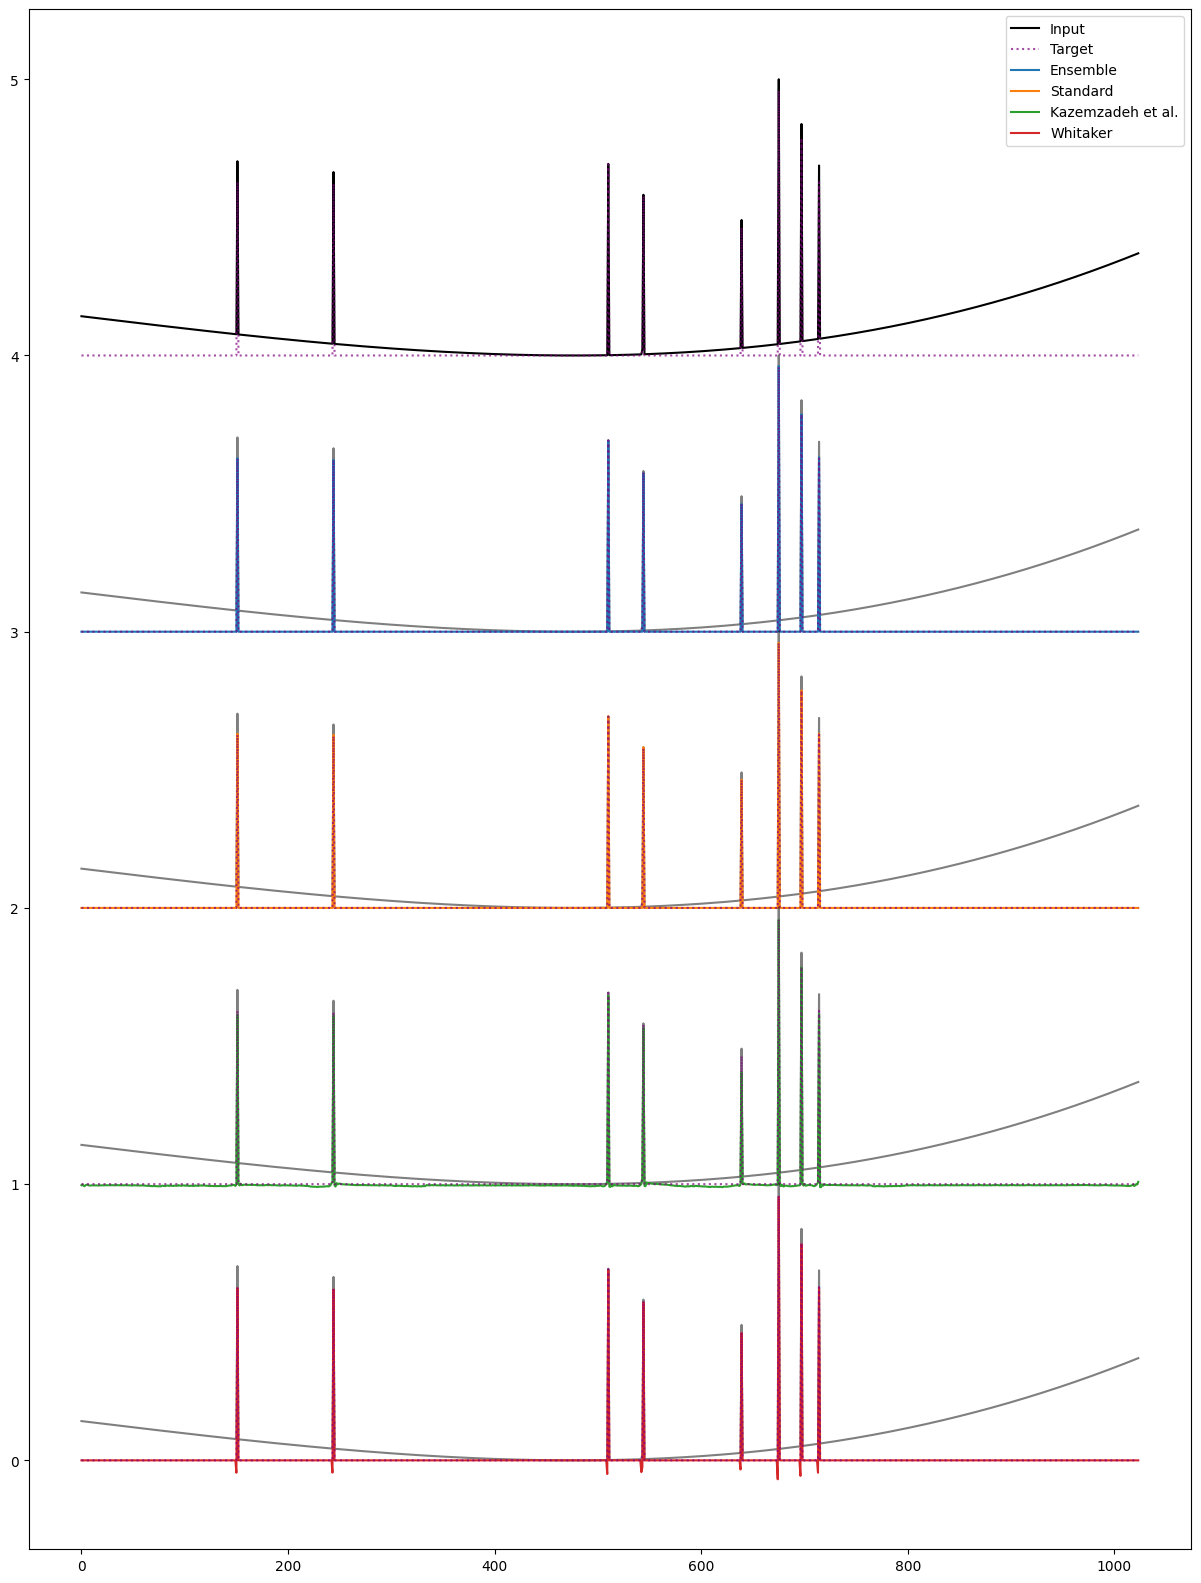

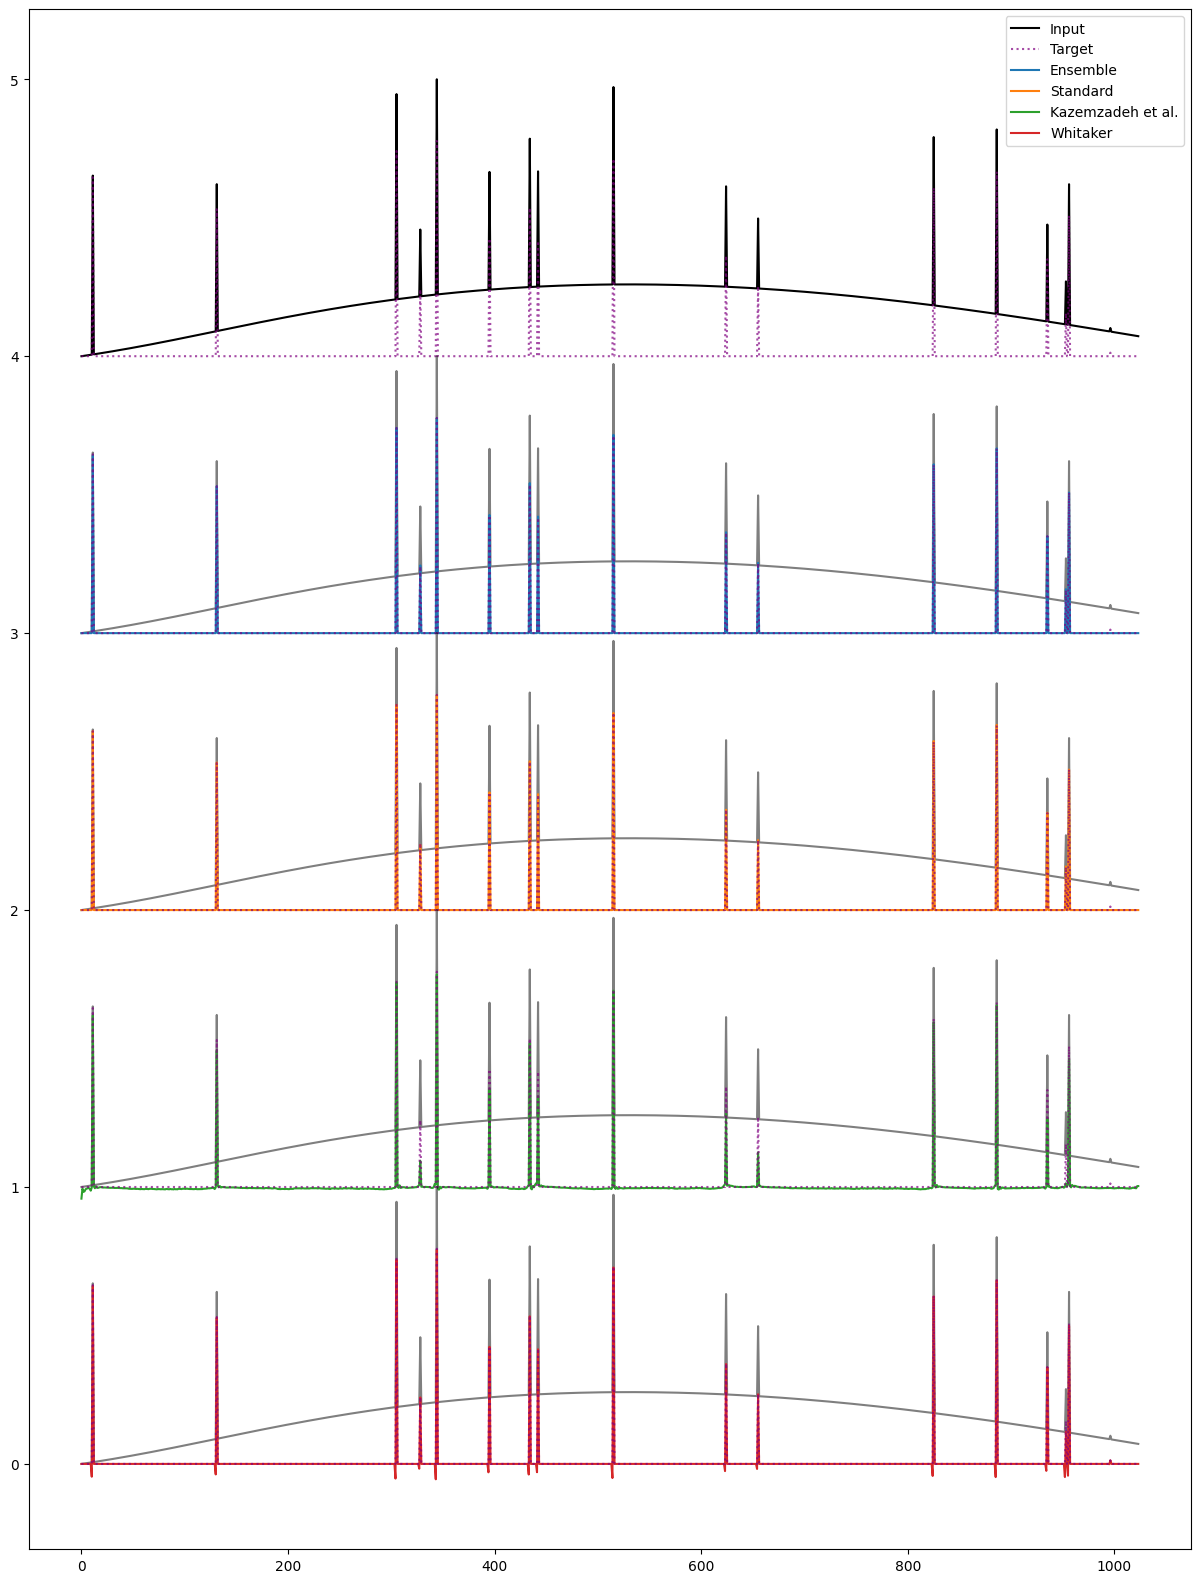

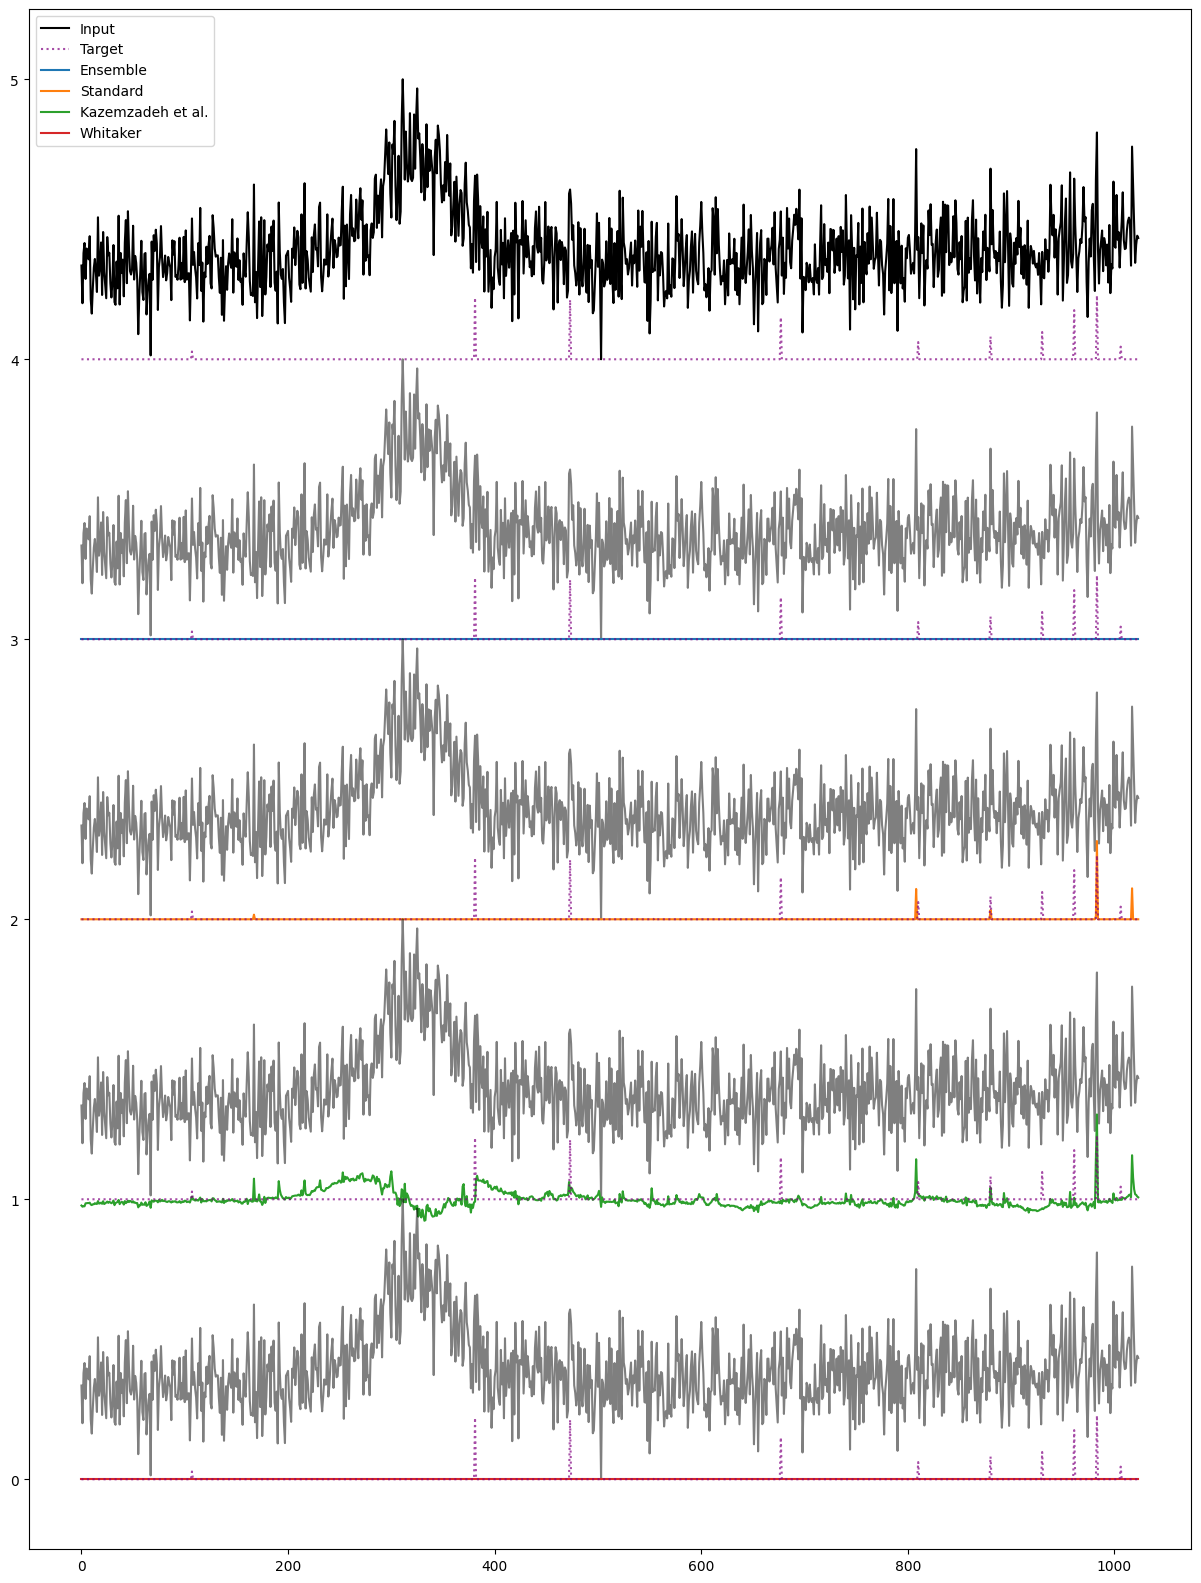

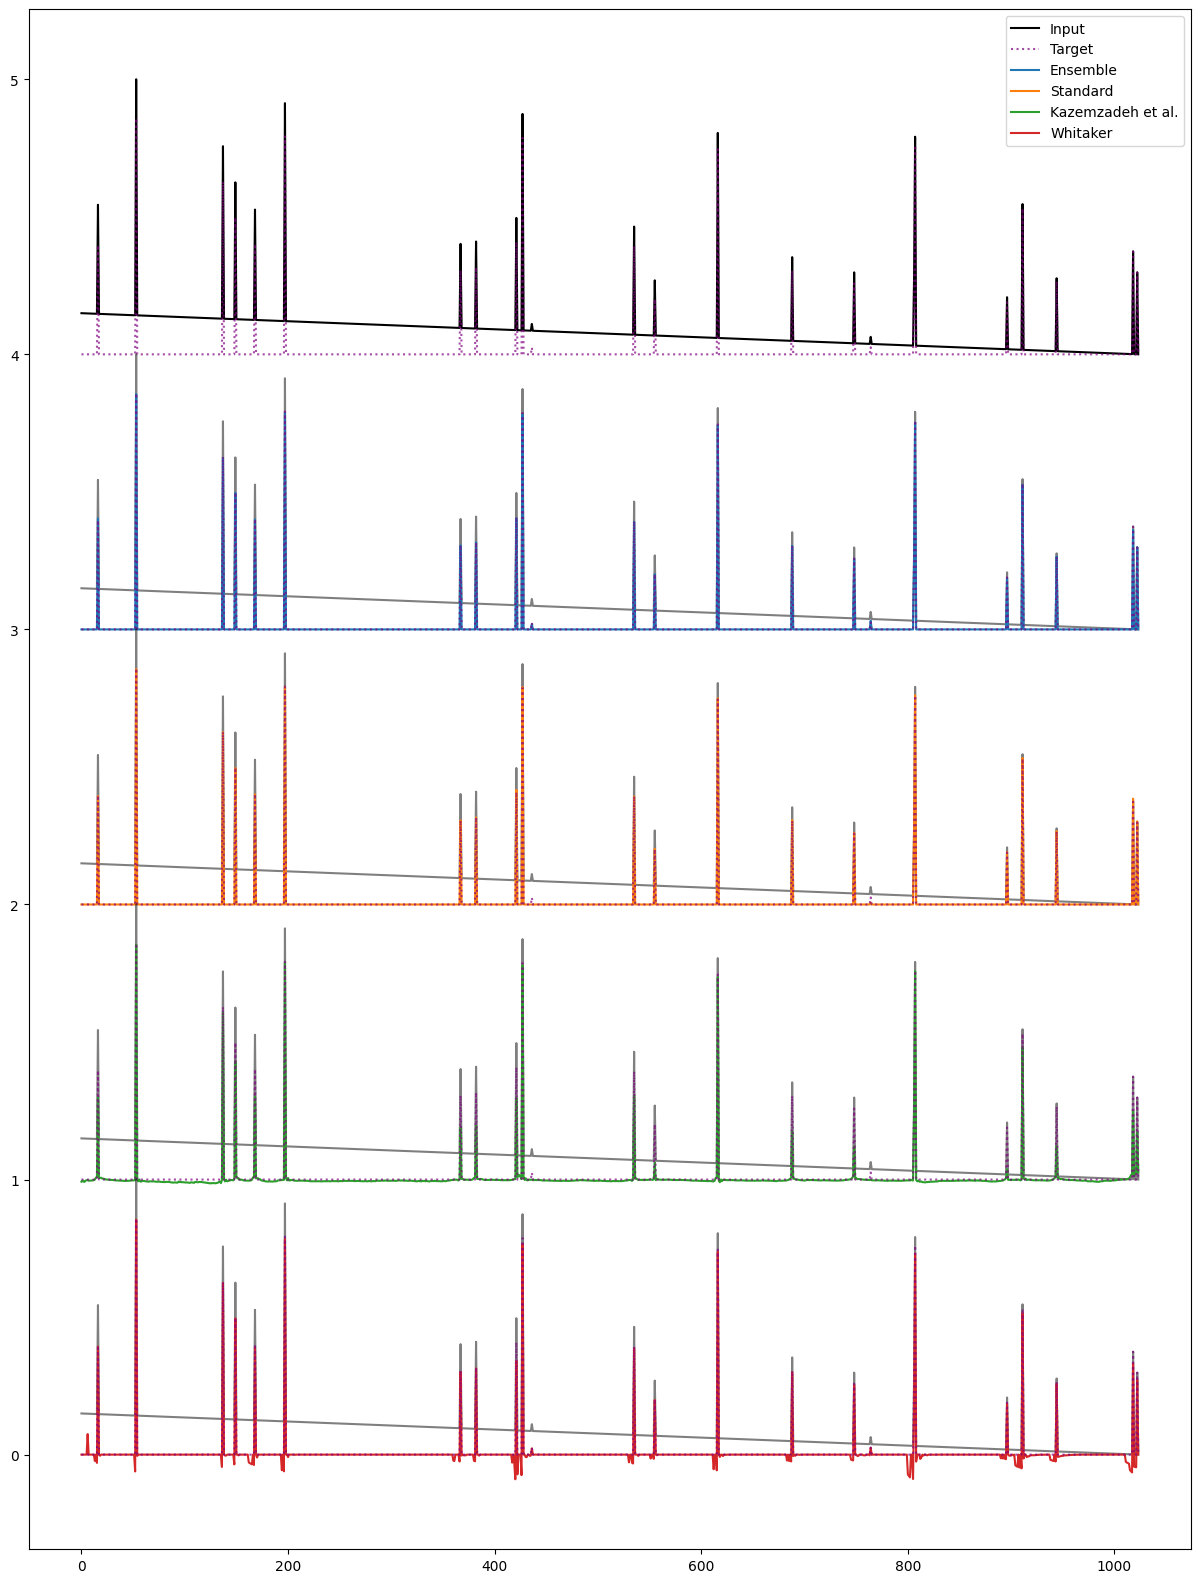

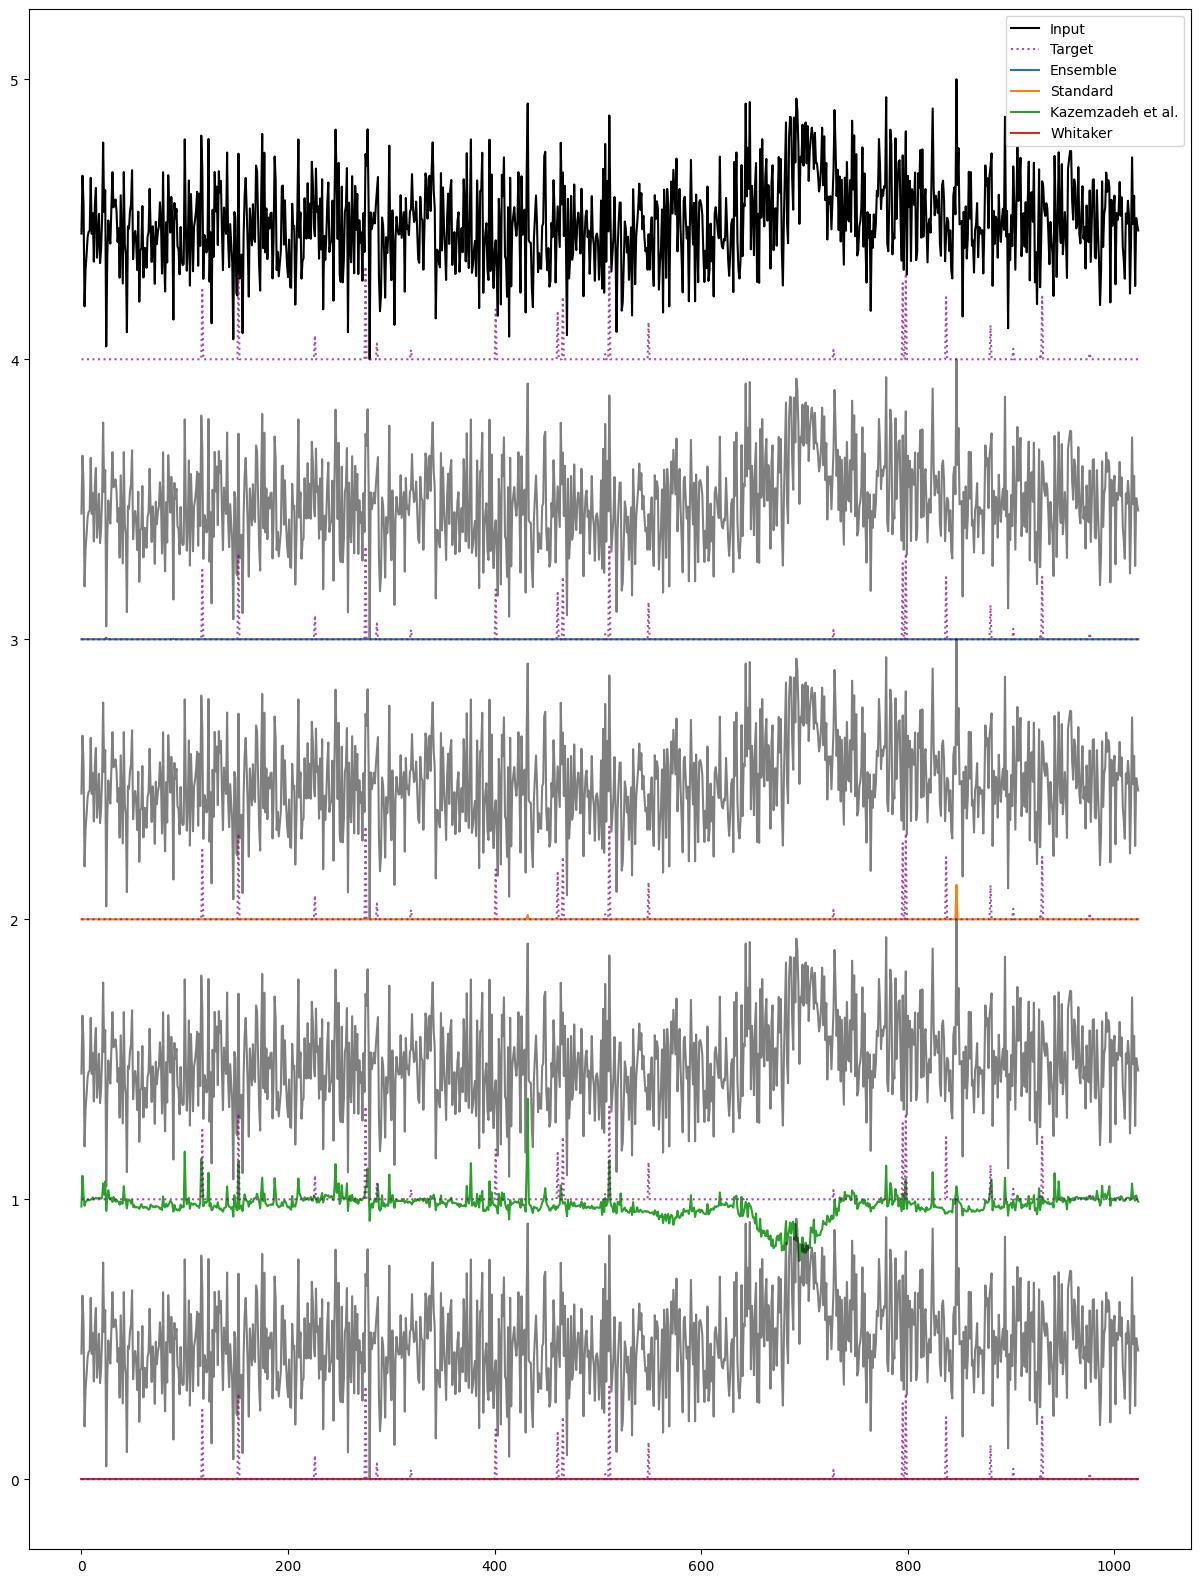

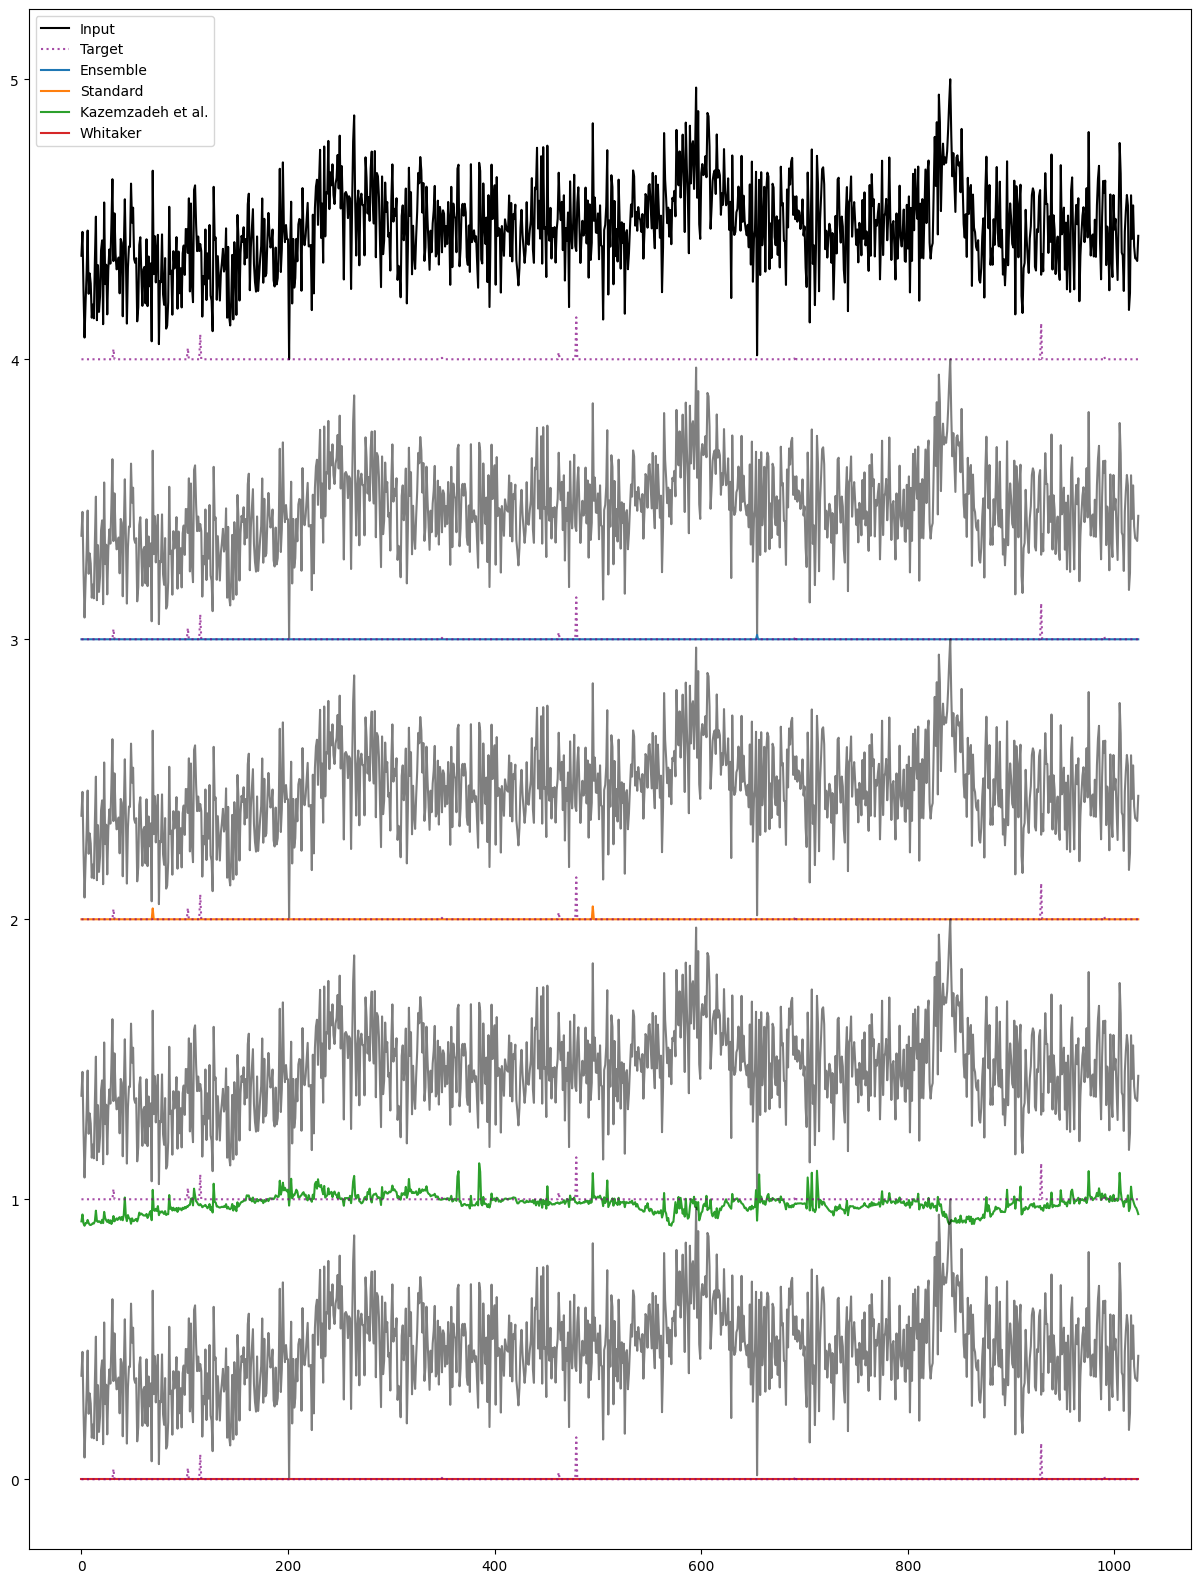

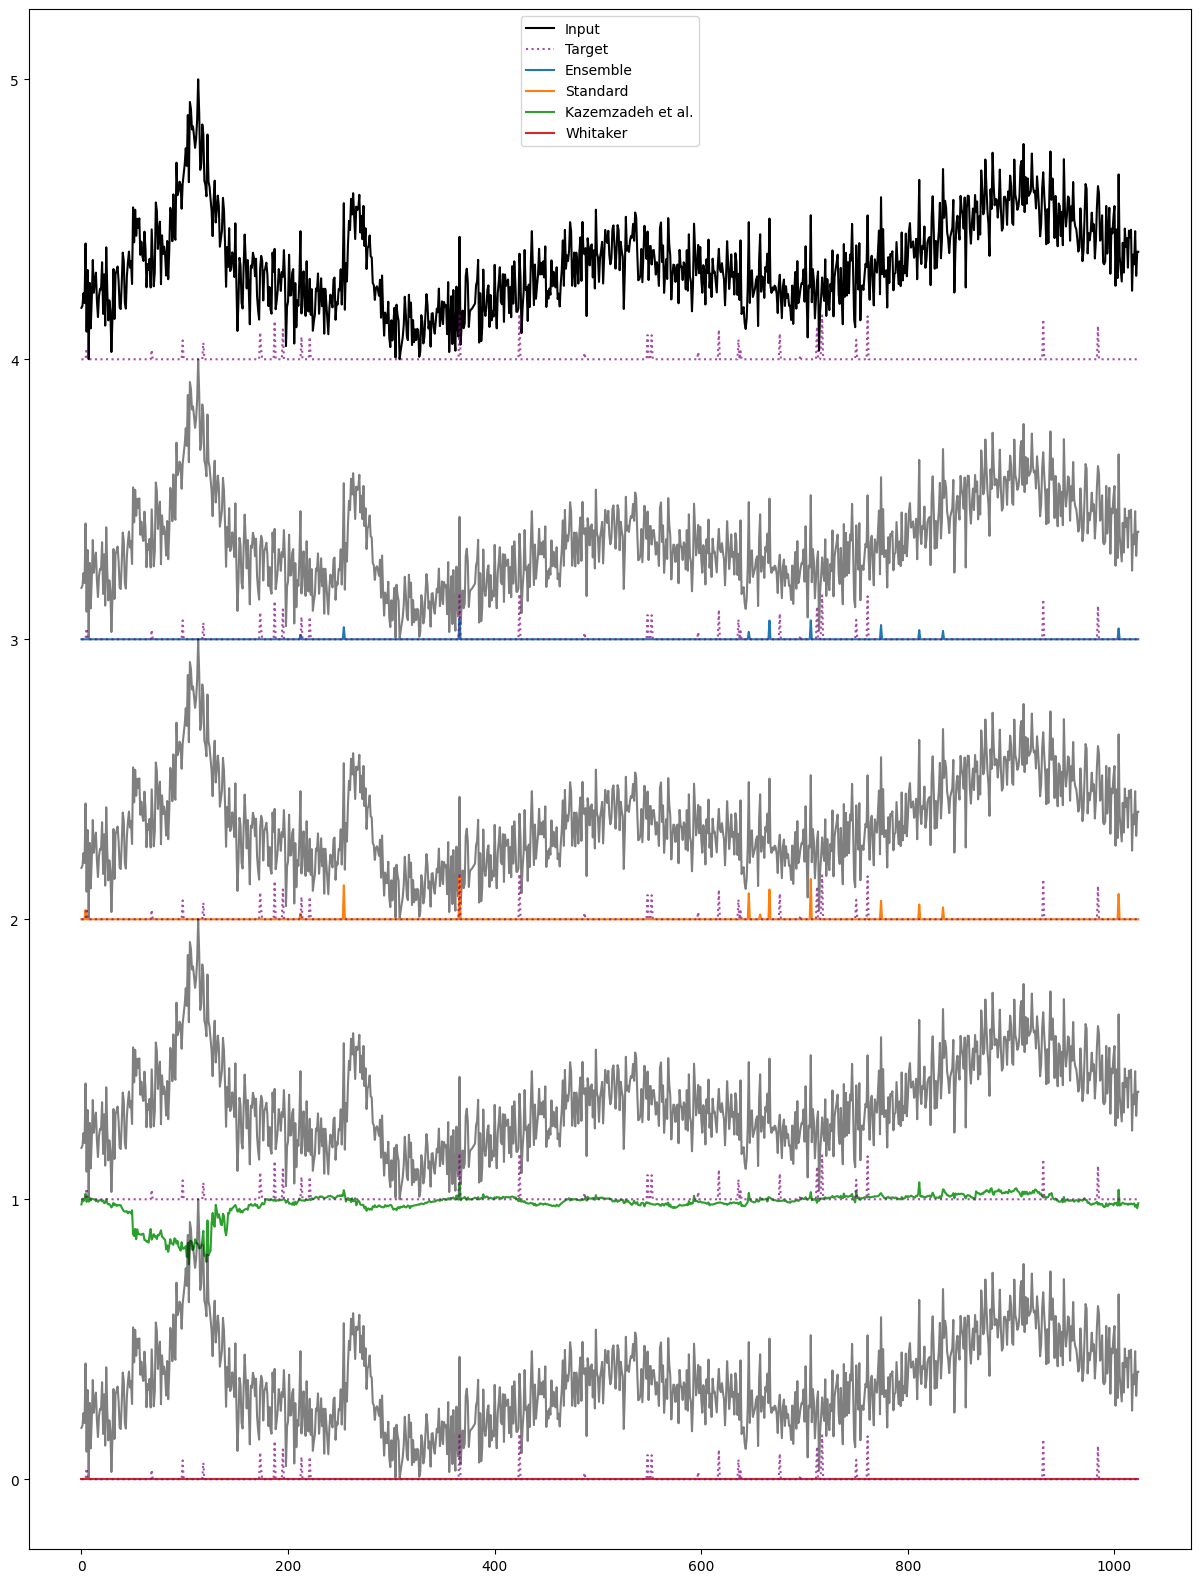

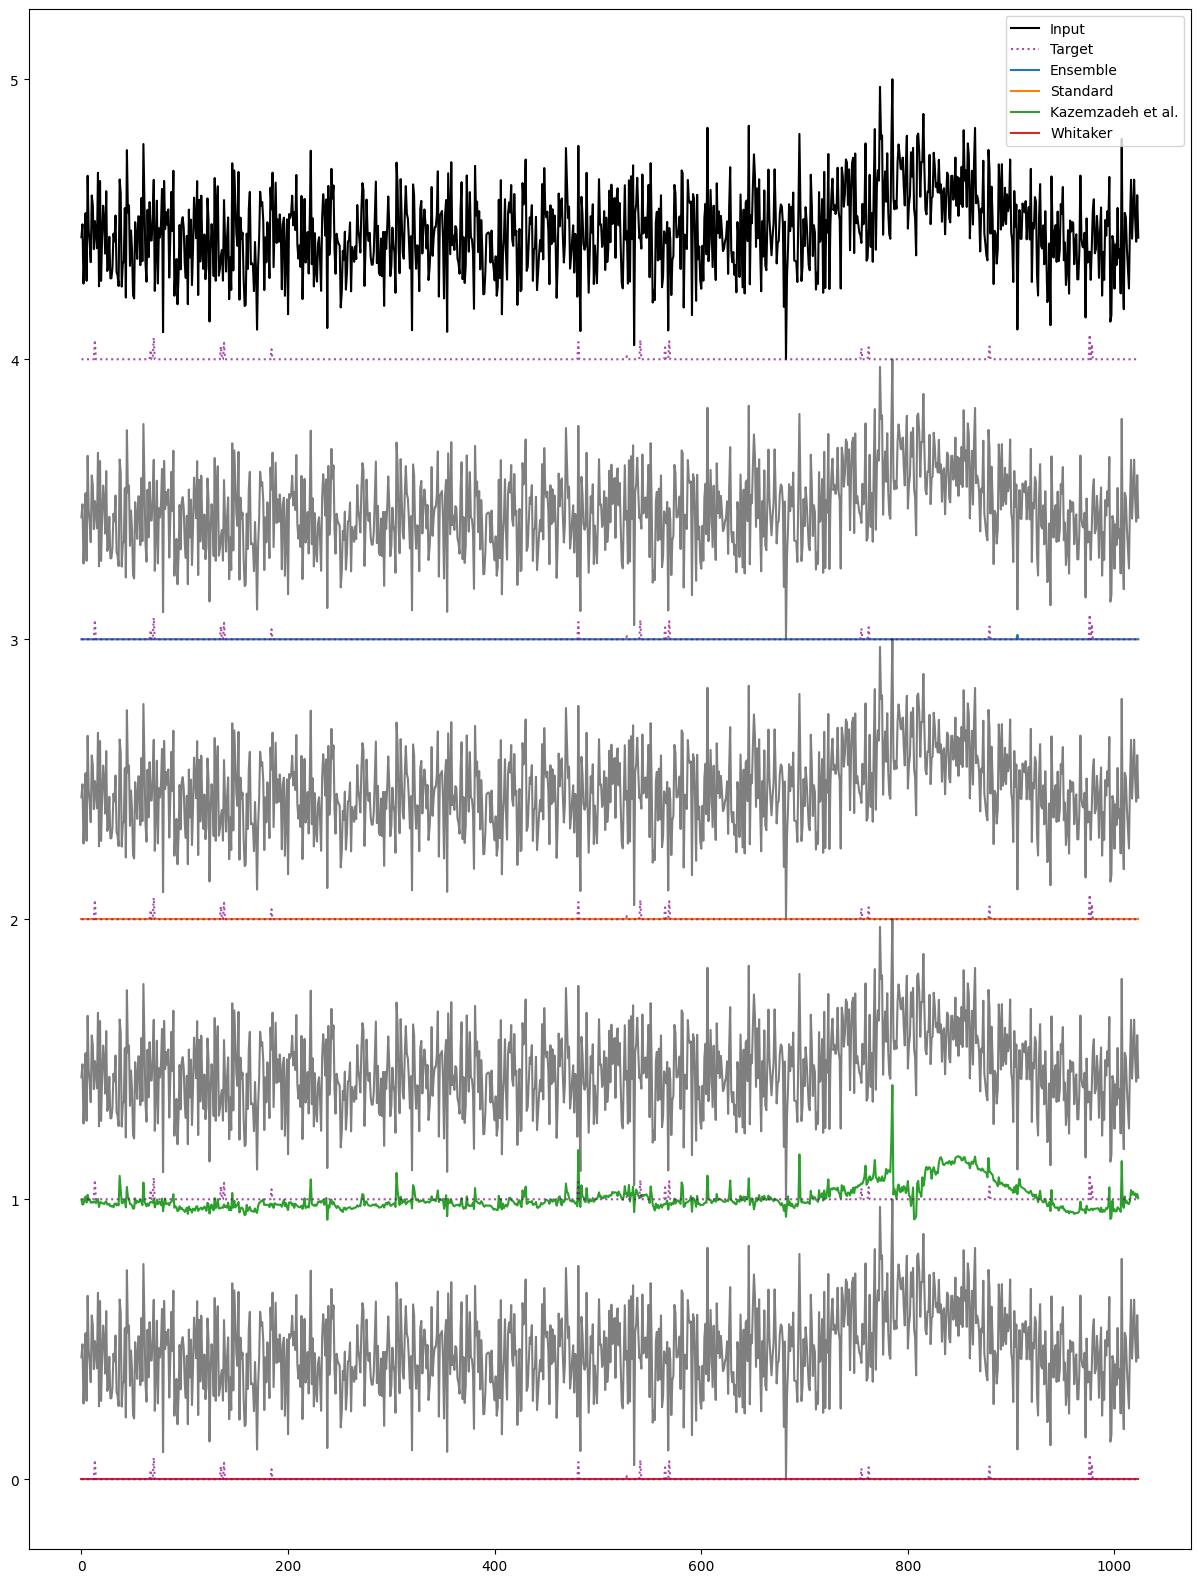

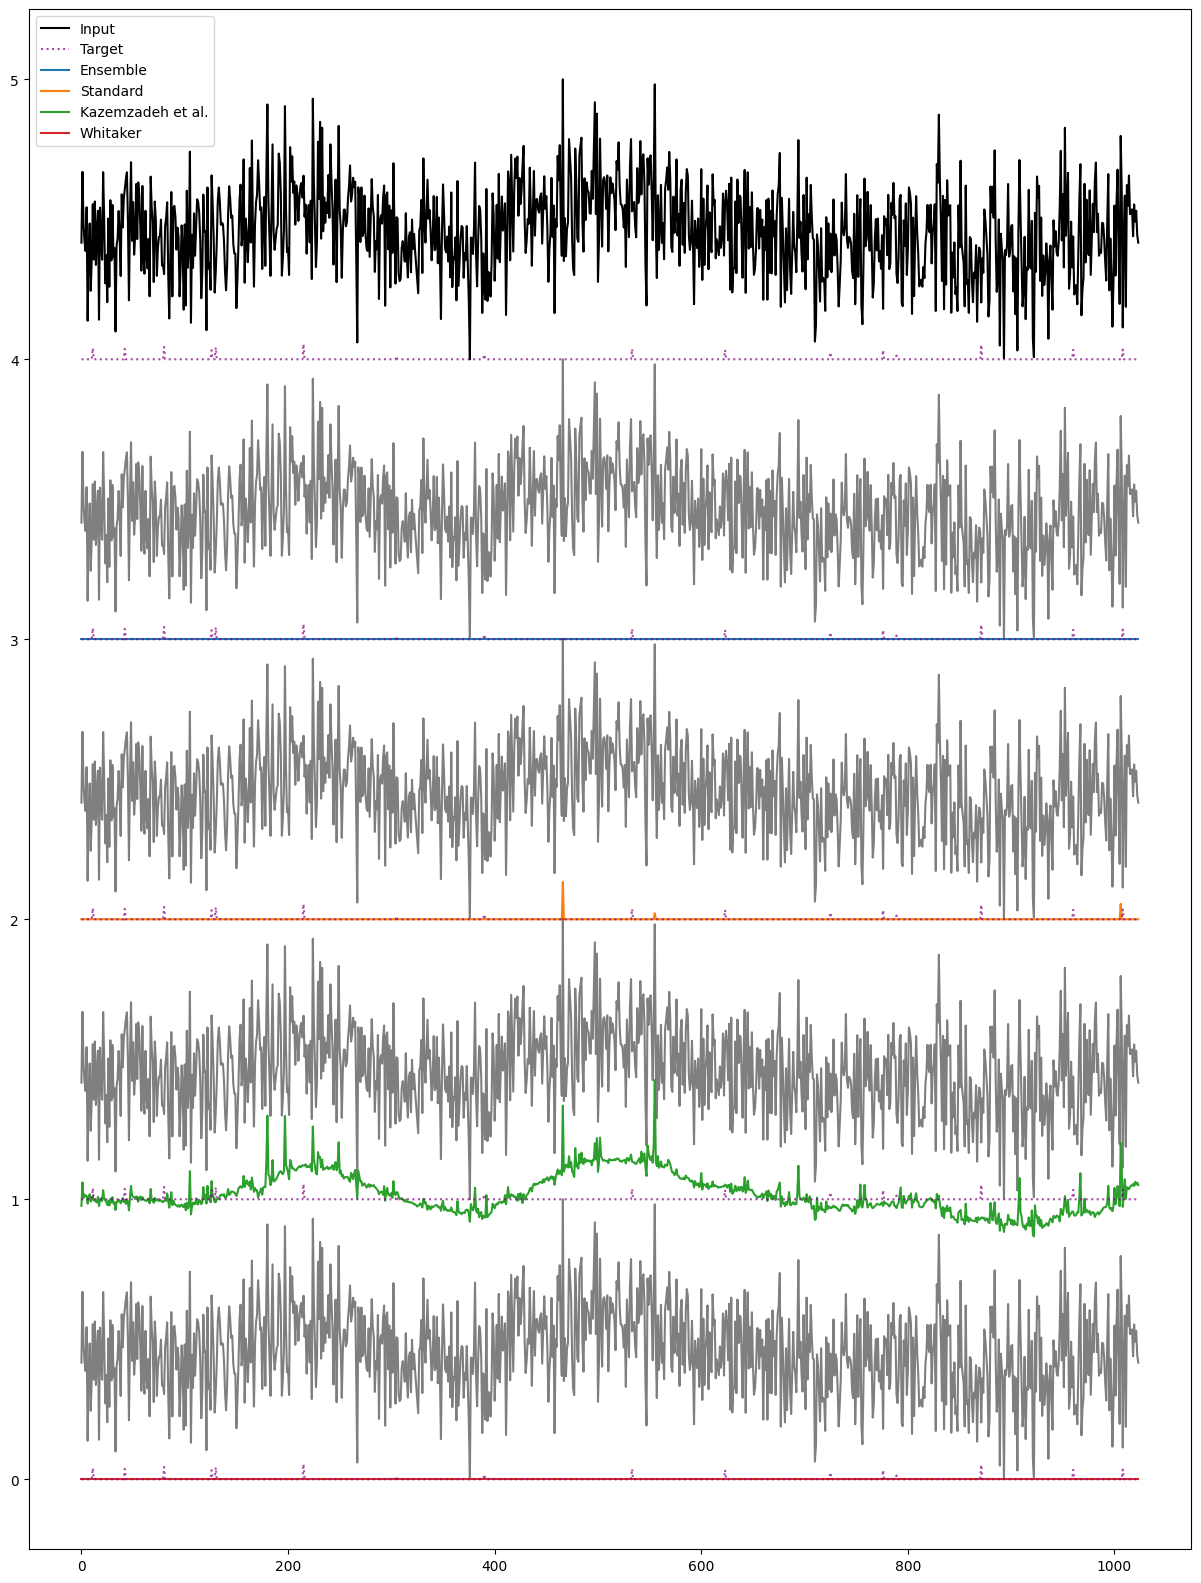

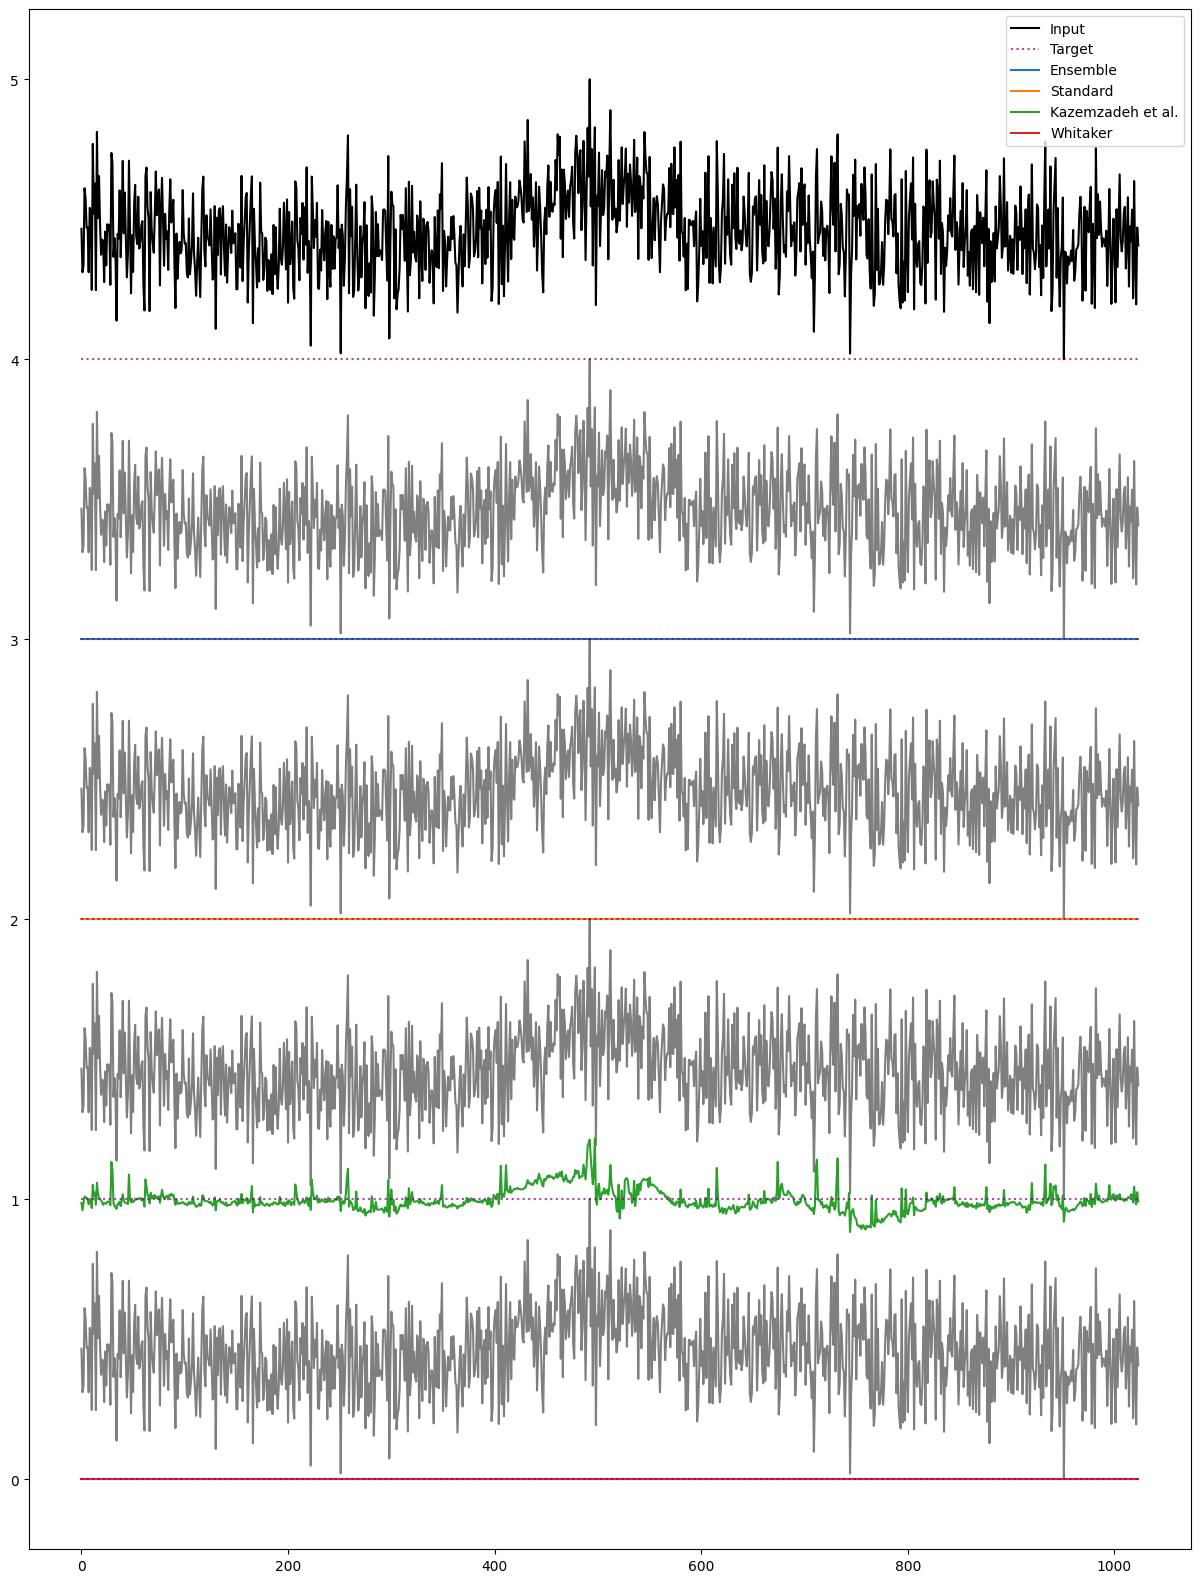

Ensemble
	RMSE: 
		Mean: 0.01 
		Median: 0.01 
		Variance: 0.0
	Max error: 
		Mean: 0.14 
		Median: 0.11 
		Variance: 0.02
Standard
	RMSE: 
		Mean: 0.01 
		Median: 0.01 
		Variance: 0.0
	Max error: 
		Mean: 0.15 
		Median: 0.13 
		Variance: 0.01
Kazemzadeh et al.
	RMSE: 
		Mean: 0.04 
		Median: 0.04 
		Variance: 0.0
	Max error: 
		Mean: 0.26 
		Median: 0.25 
		Variance: 0.01
Whitaker
	RMSE: 
		Mean: 0.01 
		Median: 0.01 
		Variance: 0.0
	Max error: 
		Mean: 0.19 
		Median: 0.16 
		Variance: 0.03


In [3]:
d_path = "data/Generated_data/"
datasets = [
           (d_path+"X_1024_10_300.npy", d_path+"y_cosmic_rays_1024_10_300.npy", d_path+"y_baseline_1024_10_300.npy"),
           ]
metrics_dict = {}
full_metrics_dict = {}
for data in datasets:

    # Load the dataset we want to evaluate
    X = np.load(data[0])
    target = np.load(data[1])
    baselines = np.load(data[2]) # The cascaded model can capture CR in the baselines. We will attempt to extract those.

    # DL-predictions
    
    # Ensemble model predictions
    ensemble_preds = ensemble_model.predict(X, verbose = 0)
    # Get CR
    ensemble_preds = ensemble_preds[1]
    
    # Standard model
    standard_preds = standard_model.predict(X, verbose = 0)
    # Get CR
    standard_preds = standard_preds[1]

    # Cascaded preds, multiply X by 1000 to set the required input shape
    cascaded_preds = cascade.predict(X * 1000, verbose = 0) # Baseline corrected spectrum
        # Divide by 1000 to return to the normalized scope
    cascaded_bl = np.squeeze(X - cascaded_preds[0]/1000) # baseline is achieved by removing the baseline corrected spectrum from the input

    cascaded_preds =  cascaded_bl - baselines # Removing the true baselines results in CR residue

    ## Spectrapepper method

    # Whitaker and Hayes
    # https://www.sciencedirect.com/science/article/pii/S0169743918301758?via%3Dihub
    Whitaker = spectrapepper.cosmicdd(X, th=6, asy=0.6745, m=7)
    whitaker_preds = X - Whitaker
    
    method_preds = [ensemble_preds, standard_preds, cascaded_preds, whitaker_preds]
    method_names = ["Ensemble", "Standard", "Kazemzadeh et al.", "Whitaker"]

    # Save the figures in a unique folder for potential use later
    path = "Figures/"+ data[1].split("/")[-1]
    if not os.path.exists(path):
        os.mkdir(path)
    
    for spec_ix in range(10): 
        plt.figure(figsize=(15, 20))
        plt.plot(X[spec_ix]+len(method_preds), label = "Input", color = "Black")
        plt.plot(target[spec_ix]+len(method_preds), label = "Target",
                 color = "purple", ls =":", alpha = 0.7)
        for i in range(len(method_preds)):
            indent = len(method_preds) - i -1
    
            plt.plot(X[spec_ix] + indent, color = "Black", alpha = 0.5)
            plt.plot(method_preds[i][spec_ix] + indent, label = method_names[i])
            plt.plot(target[spec_ix] + indent, color = "purple", ls =":", alpha = 0.7)
            
    
        plt.legend()
        plt.savefig(path + "/CosmicRays" + str(spec_ix) + ".pdf", format="pdf",)
        plt.show()
    
    # Gather the metrics
    metrics_dict[data[0]] = {}
    full_metrics_dict[data[0]] = {}
    for preds, name in zip(method_preds, method_names):
        
        print(name)

        RMSE_metrics = []
        MaxError_metrics = []
        for spec, p in zip(target, np.squeeze(preds)):
            RMSE_metrics.append(root_mean_squared_error(p, spec)) # I defined the metrics with true, pred order...
            MaxError_metrics.append(metrics.max_error(spec, p))

        
        # Print statistics
        print("\tRMSE:",
              "\n\t\tMean:", np.round(np.mean(RMSE_metrics), 2),
              "\n\t\tMedian:", np.round(np.median(RMSE_metrics), 2),
              "\n\t\tVariance:", np.round(np.var(RMSE_metrics), 2))
        
        print("\tMax error:",
              "\n\t\tMean:", np.round(np.mean(MaxError_metrics), 2),
              "\n\t\tMedian:", np.round(np.median(MaxError_metrics), 2),
              "\n\t\tVariance:", np.round(np.var(MaxError_metrics), 2))
    

        metrics_dict[data[0]][name] = [np.mean(RMSE_metrics), np.median(RMSE_metrics), np.var(RMSE_metrics),
                                       np.mean(MaxError_metrics), np.median(MaxError_metrics),
                                       np.var(MaxError_metrics)]
        full_metrics_dict[data[0]][name] = [np.array(RMSE_metrics), np.array(MaxError_metrics)]

In [4]:
path = "Data/Outputs/CR/"
for data_name in full_metrics_dict.keys():
    for model_name in full_metrics_dict[data_name].keys():
        data = full_metrics_dict[data_name][model_name]

        np.save(path + model_name + ".np", data)

In [5]:
header = ["RMSE:mean", "RMSE:median", "RMSE:variance", "MaxError:mean", "MaxError:median", "MaxError:variance"]

with pd.ExcelWriter('Results/CosmicRayComparisons.xlsx') as writer:
    for key in metrics_dict.keys():

        df = pd.DataFrame.from_dict(metrics_dict[key],
                                        columns = header,
                                        orient = "index")
        filename = key.split("/")[1] + key.split("/")[2]
        df = df.round(decimals = 2).drop(columns=["RMSE:median", "MaxError:median"])
        df.to_excel(writer, sheet_name=filename)
        
        print(filename)
        df = df.style.format(decimal=',', thousands='.', precision=2)
        print(df.to_latex())

Generated_dataX_1024_10_300.npy
\begin{tabular}{lrrrr}
 & RMSE:mean & RMSE:variance & MaxError:mean & MaxError:variance \\
Ensemble & 0,01 & 0,00 & 0,14 & 0,02 \\
Standard & 0,01 & 0,00 & 0,15 & 0,01 \\
Kazemzadeh et al. & 0,04 & 0,00 & 0,26 & 0,01 \\
Whitaker & 0,01 & 0,00 & 0,19 & 0,03 \\
\end{tabular}



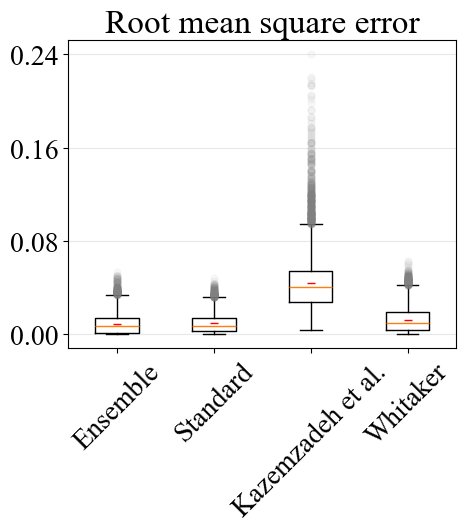

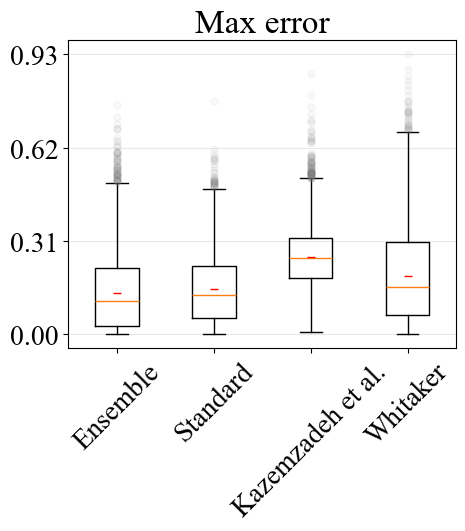

In [6]:
plt.rcParams.update({'font.size': 20})
plt.rcParams["font.family"] = "Times New Roman"
dimension = (5, 4)
num_ticks = 4
for key in full_metrics_dict.keys():

    key2 = list(full_metrics_dict[key].keys())


    # RMSE metrics
    flier_props = dict(marker='o', markerfacecolor='gray', alpha = 0.05, markersize=5,
                  linestyle='none', markeredgecolor="gray")
    mean_props = {"marker": "_", 'markerfacecolor': "Red", 'markeredgecolor': "Red"}
    
    model_metrics = [full_metrics_dict[key][k][0] for k in key2]
    fig, ax = plt.subplots(figsize = dimension)
    ax.boxplot(model_metrics,
                  labels = key2,
                  showmeans=True, 
                  flierprops = flier_props,
                  meanprops= mean_props,
                 )

    
    ax.set_title("Root mean square error")
    max_ = np.max([full_metrics_dict[key][k][0] for k in key2])
    ticks = np.linspace(0, max_, num_ticks)
    ax.set_yticks(ticks)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
    ax.set_xticklabels(key2, rotation = 45)
    plt.savefig("Figures/Metrics/CR_RMSE.png", format="png",
                bbox_inches='tight',
                dpi = 1000,
                transparent = True,
                pad_inches=0.5)
    plt.show()
    
    
    # Max error metrics
    model_metrics = [full_metrics_dict[key][k][1] for k in key2]
    fig, ax = plt.subplots(figsize = dimension)
    ax.boxplot(model_metrics,
                  labels = key2,
                 showmeans=True,
                  flierprops = flier_props,
                  meanprops= mean_props,
                 #showfliers=False,
                 )
    ax.set_title("Max error")
    max_ = np.max([full_metrics_dict[key][k][1] for k in key2])
    ticks = np.linspace(0, max_, num_ticks)
    ax.set_yticks(ticks)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
    ax.set_xticklabels(key2, rotation = 45)
    plt.savefig("Figures/Metrics/CR_MaxError.png", format="png",
                bbox_inches='tight',
                dpi = 1000,
                transparent = True,
                pad_inches=0.5)
    plt.show()